<a href="https://colab.research.google.com/github/sapirca/wine_reviews/blob/main/predictive_wine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Update flag to true if you're running a local Jupyter notebook and wants to load the dataset from the memory, otherwise set to false (for debug / when using google colab)

In [2]:
LOCAL_JUPYTER = False

# Understanding Wine Trends across different attributes

Authors - Eliezer Pekar 212029052 | Sapir Caduri 303083653


The goal of this research paper is to develop a predictive model to identify the quality of wine based on various attributes such as location, price, and others. The research is using a Wine Review dataset from Kaggle, that is motivated by the documentary "Somm" which explores the world of master sommeliers and their ability to identify wines through blind tasting.

# The predictive Task




In this paper we explore the relationship between wine attributes (e.g., price, rating, regions) and their quality - we assume that the higher the pricer the higher the rating, we can try to predict the rating of the winer based on the price.



# 1. The Dataset

The Wine Reviews dataset contains information about various wines, including details such as country of origin, designation, points, price, province, region, variety, and winery. Number of rows: 119,955 (~25k unique reviews), 14  attributes


### Challenges with the data


The Wine Reviews dataset presents several challenges and difficulties that may arise during data analysis and modeling:
1. Missing Data/Empty rows: Designation 29% null, Null cells: Region 16% null, region2 61% null, taster_name 20% null, taster_twitter_handle 24% empty
2. Free text: The Description column contains textual descriptions of the wines
3. Biasing: Tiger Voss 20% of the reviews (@vossroger)
4. Outlier:
5. Imbalance: wine variety or quality = Some wine varieties or regions are heavily represented in the dataset = Pinot Noir 10%, Chardonnay 9%, other 81%, Region 2 9% Central coast
6. Categorical Variables: The dataset contains categorical variables such as "Winery" with 16K unique wineries (of 199K rows)
7. High Dimensionality: The dataset have a large number of attributes - can pose challenges for modeling and visualization

In [5]:
# @title Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import contextlib
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline   # Import the Pipeline class
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from io import StringIO

In [7]:
if not LOCAL_JUPYTER:
    from google.colab import files

    !pip install -q kaggle

    with StringIO() as temp_output, contextlib.redirect_stdout(temp_output):
        files.upload() # This won't print to the screen the Kaggle API key

    # Move the API key into the required directory
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets download -d zynicide/wine-reviews
else: # Jupyter
    # the dataset is in the github repository
    pass

 98% 50.0M/50.9M [00:02<00:00, 32.8MB/s]
100% 50.9M/50.9M [00:02<00:00, 22.0MB/s]


In [9]:
!unzip -q wine-reviews.zip -d wine-reviews

In [10]:
!ls ./wine-reviews

winemag-data-130k-v2.csv  winemag-data-130k-v2.json  winemag-data_first150k.csv


# 2. Analyzing the dataset

The dataset initially appears to contain three files; however, analysis shows they are actually different versions of the same dataset.

In [11]:
wine_data_1 = pd.read_csv("./wine-reviews/winemag-data_first150k.csv")
# wine_data_2 = pd.read_json("./wine-reviews/winemag-data-130k-v2.json") # Same data, different format (json vs csv)
wine_data_3 = pd.read_csv("./wine-reviews/winemag-data-130k-v2.csv")

In [13]:
wine_data_1.head(1)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz


In [12]:
wine_data_3.head(1)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [14]:
def print_wine_attributes(wine_data):
  print("Wine attributes: ")
  for idx, column_name in enumerate(wine_data.columns):
      if pd.api.types.is_numeric_dtype(wine_data[column_name]):
          value_min = wine_data[column_name].min()
          value_max = wine_data[column_name].max()
          print(f"{idx}. {column_name} (Range: {value_min} - {value_max})")
      else:
          print(f"{idx}. {column_name}") # Range: Not applicable (non-numeric data)
          pass

The Wine dataset attributes

In [16]:
print(wine_data_1.shape)
print()
print_wine_attributes(wine_data_1)

(150930, 11)

Wine attributes: 
0. Unnamed: 0 (Range: 0 - 150929)
1. country
2. description
3. designation
4. points (Range: 80 - 100)
5. price (Range: 4.0 - 2300.0)
6. province
7. region_1
8. region_2
9. variety
10. winery


In [15]:
print(wine_data_3.shape)
print()
print_wine_attributes(wine_data_3)

(129971, 14)

Wine attributes: 
0. Unnamed: 0 (Range: 0 - 129970)
1. country
2. description
3. designation
4. points (Range: 80 - 100)
5. price (Range: 4.0 - 3300.0)
6. province
7. region_1
8. region_2
9. taster_name
10. taster_twitter_handle
11. title
12. variety
13. winery


The file "/wine-reviews/winemag-data-130k-v2.csv" represents the most updated version of the wine review dataset. This version includes three new fields (Title, Taster Name, and Taster Twitter Handle), fixes duplicate entries found in earlier releases,  and adds approximately 25,000 unique wine reviews.

In [17]:
wine_data = wine_data_3

The problem that we stated that we want to inquire is if the price can be predicted by other elements of the data.

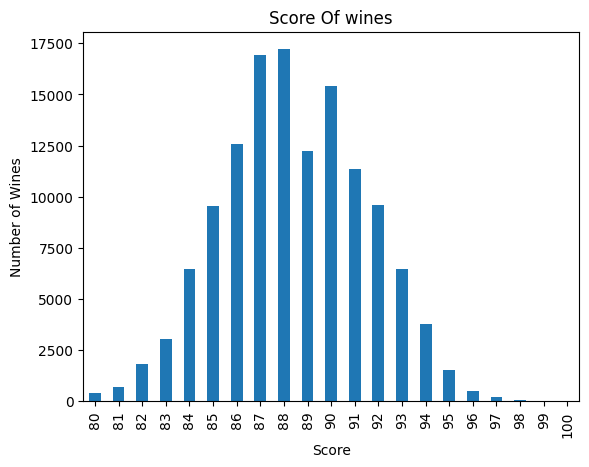

In [18]:
wine_data['points'].value_counts().sort_index().plot.bar(title = 'Score Of wines')
plt.xlabel('Score')  # Adding x-axis label
plt.ylabel('Number of Wines')  # Adding y-axis label
plt.show()

As we can see the Scores are almost gaussian distributed. The minimum value is 80.

# 3. Define a prediction problem

As mentioned, predict wine quality (also referrred as points / wine review's score) based on the wine attributes.

['price', 'country', 'variety'] -> predict 'points'

# 4. Sanitize and organize your dataset

In [28]:
# Handling missing values
# drop rows with any missing value in 'Price', 'Country', or 'Variety'
wine_data_filtered = wine_data
wine_data_filtered.dropna(subset=['price', 'country', 'variety'], inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
wine_data_filtered['country'] = label_encoder.fit_transform(wine_data['country'])
wine_data_filtered['variety'] = label_encoder.fit_transform(wine_data['variety'])

# Select features and target
X = wine_data_filtered[['price', 'country', 'variety']]
y = wine_data_filtered['points']


# 5. meaningful data visualizations

Text(0, 0.5, 'Number of Wines')

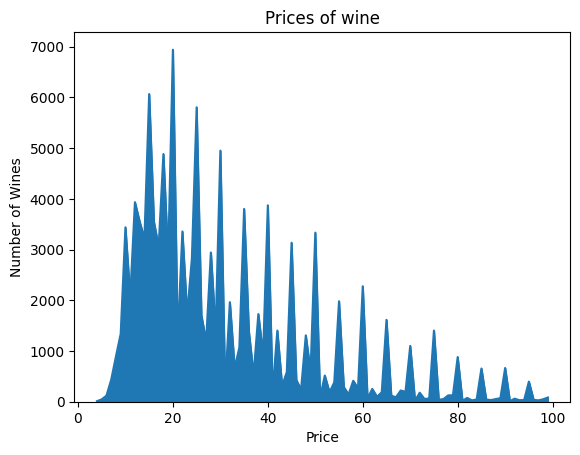

In [19]:
wine_data['price'][wine_data['price'] < 100].value_counts().sort_index().plot.area(
    title = 'Prices of wine')
plt.xlabel('Price')
plt.ylabel('Number of Wines')

The displayed area plot illustrates the distribution of wine prices under $100. Notably, the distribution exhibits a pronounced right skew, indicating a higher frequency of lower-priced wines within the dataset. This skewness suggests that more affordable wine options overwhelmingly outnumber their higher-priced counterparts. This will make it harder to predict higher-priced wines.

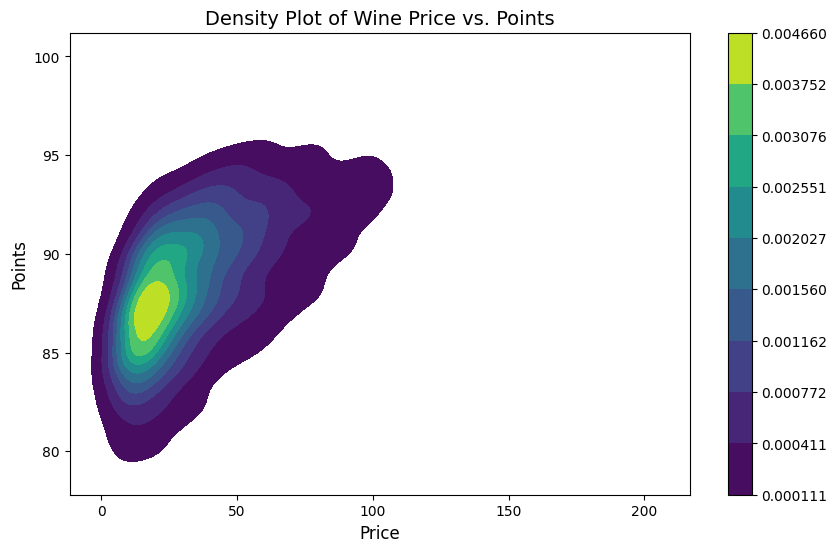

In [20]:
data_sample = wine_data[wine_data['price'] < 200].loc[:, ['price', 'points']].dropna().sample(5000)

# Create a KDE plot with specified colors and labels
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=data_sample['price'],
    y=data_sample['points'],
    cmap="viridis",  # Color map for the density
    fill=True,       # Fill the density plot with color
    cbar=True,       # Add a color bar
    thresh=0.05,     # Minimum density threshold for coloring
)

# Adding labels and title
plt.xlabel('Price', fontsize=12)
plt.ylabel('Points', fontsize=12)
plt.title('Density Plot of Wine Price vs. Points', fontsize=14)

# Since the color bar is included and we're not comparing groups, we don't need a legend here
plt.show()

The graph is a two-dimensional Kernel Density Estimate (KDE) plot that visualizes the joint distribution of wine prices and quality points. The color gradients represent the density of observations, with warmer colors indicating higher concentrations of wines within specific price and point ranges.

In [21]:
# To find the correlation of the Price and Points
correlation = wine_data[['price', 'points']].corr().iloc[0, 1]
print(f"The Pearson correlation coefficient between price and points is: {correlation:.2f}")

The Pearson correlation coefficient between price and points is: 0.42


A correlation coefficient of 0.42 suggests a moderate positive relationship between the price and points of the wines in the dataset. However this relationship is not particularly strong.

<Axes: xlabel='variety', ylabel='points'>

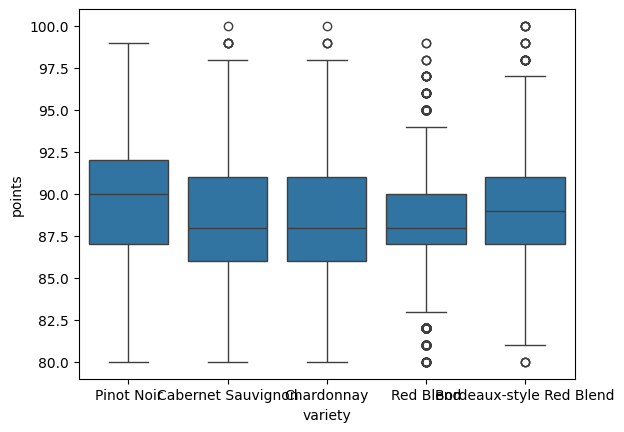

In [22]:
df1 = wine_data[wine_data.variety.isin(wine_data.variety.value_counts().head(5).index)]

sns.boxplot(
    x = 'variety',
    y = 'points',
    data = df1
)

In the above we can see that different varieties of wine have different distribution of points.

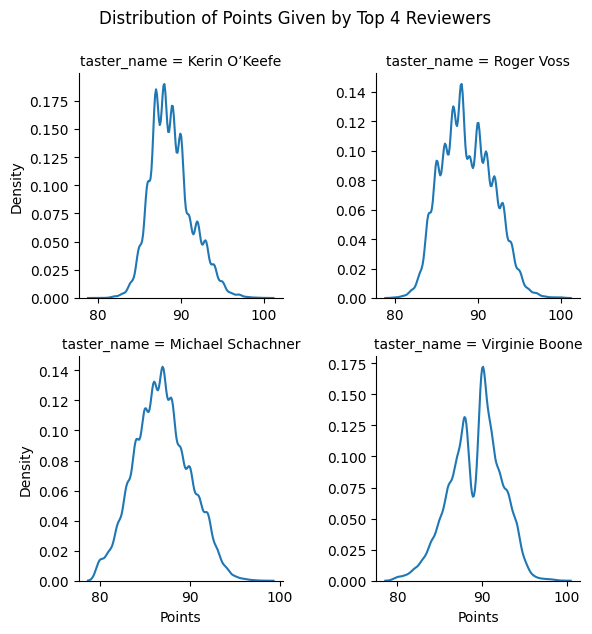

In [23]:
top_reviewers = wine_data['taster_name'].value_counts().nlargest(4).index

# Filter the data to include only the top reviewers
top_reviewers_data = wine_data[wine_data['taster_name'].isin(top_reviewers)]

# Create a FacetGrid KDE plot for the point distributions of the top 4 reviewers
g = sns.FacetGrid(top_reviewers_data, col='taster_name', col_wrap=2, sharex=False, sharey=False)
g.map(sns.kdeplot, 'points')

g.fig.suptitle('Distribution of Points Given by Top 4 Reviewers', y=1.05)
g.set_axis_labels('Points', 'Density')
plt.show()

We can see that different reviewers have different point distributions. In the histogram below we can see that most of the data is based on a small group of reviewers.

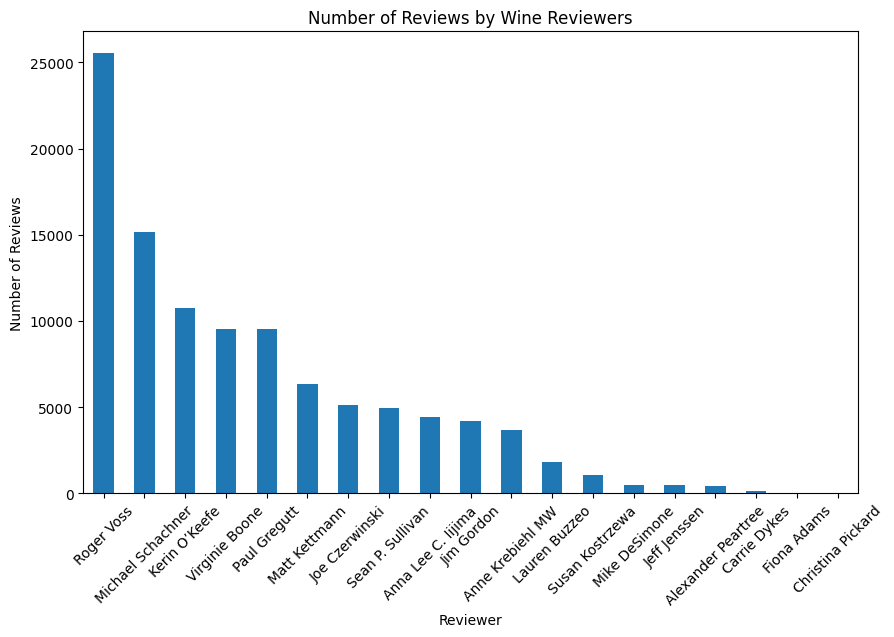

In [24]:
review_counts = wine_data['taster_name'].value_counts()

plt.figure(figsize=(10, 6))
review_counts.plot(kind='bar')
plt.title('Number of Reviews by Wine Reviewers')
plt.xlabel('Reviewer')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()


# 6. Benchmark Pipeline

In [38]:
# Split the datset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6.1 Basic model using xgboost

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [31]:
# @title Training
with StringIO() as temp_output, contextlib.redirect_stdout(temp_output):
  model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
  model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


### Inference

In [43]:
predictions = model.predict(X_test)

## 6.2 Evaluating Basic Model

In [44]:
def evaluate_model(y_true, predictions):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, predictions)
    print(f"MAE:  {mae:.2f}")
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.2f}")

In [45]:
evaluate_model(y_test, predictions)

MAE:  1.80
MSE:  5.20
RMSE: 2.28
R²:   0.44


We can see that the model has moderate accuracy, and that there's room for improvement.

The error of around 2 points is noticeable in the context of wine ratings. Since the score is between 0-10, an average error of around 2 points can be significant.

R² - the model accounts for a portion of 44% of the factors influencing wine quality, but over half the variation remains unexplained.

It is a good starting point but there's still a lot of room to imporve.

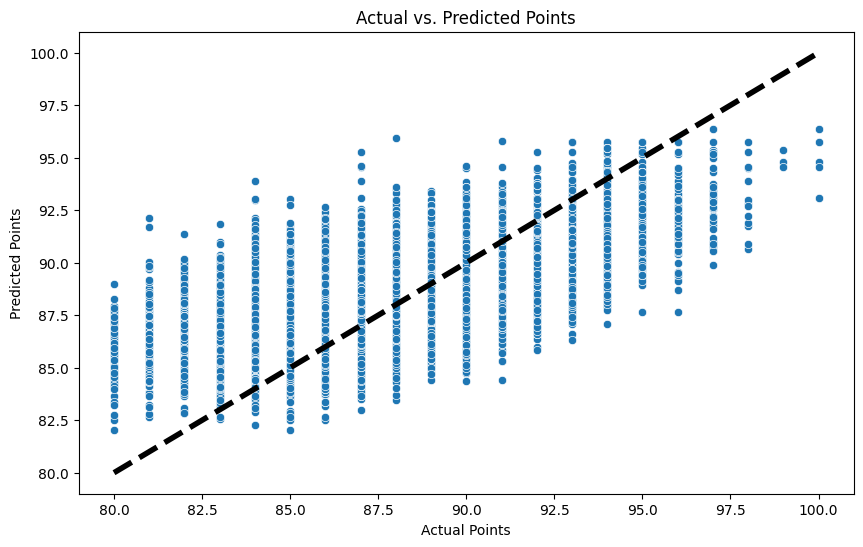

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line for reference
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs. Predicted Points')
plt.show()


This scatter plot displays the relationship between actual and predicted points.
The dashed diagonal line represents the line of perfect predictions, where the predicted points would equal the actual points.

The plot below reveals that the basic model has moderate predictive power, the predictions deviate significantly from the ideal diagonal line, demonstrating limited accuracy. While the model shows a general ability to predict higher scores for higher quality wines, the slope of this trend doesn't match the ideal expectation. Additionally, the model exhibits a bias, initially overestimating scores for wines around 80 points and then underestimating scores for wines rated around 100 points.

These observations suggest the need for model refinement to improve its prediction accuracy and address the observed biases.

## 6.3  10-fold cross-validation

In [40]:
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')
print(scores)

[-1.80256515 -1.78566128 -1.78359089 -1.86965564 -1.75611144 -1.7229939
 -1.816586   -1.80736164 -1.80063704 -1.86068903]


The plot below illustrates the performance of the XGBRegressor model across ten different folds of cross-validation, using Mean Absolute Error (MAE) as the evaluation metric. Each point on the plot represents the MAE for a single fold; lower values indicate better performance. The model demonstrates a consistent range of MAE values between approximately 1.72 and 1.87, with slight fluctuations across folds, suggesting stable performance despite variations in the test data. The consistency in MAE scores indicates that the model is likely not overfitting to a particular subset of the data and might generalize well to unseen data."

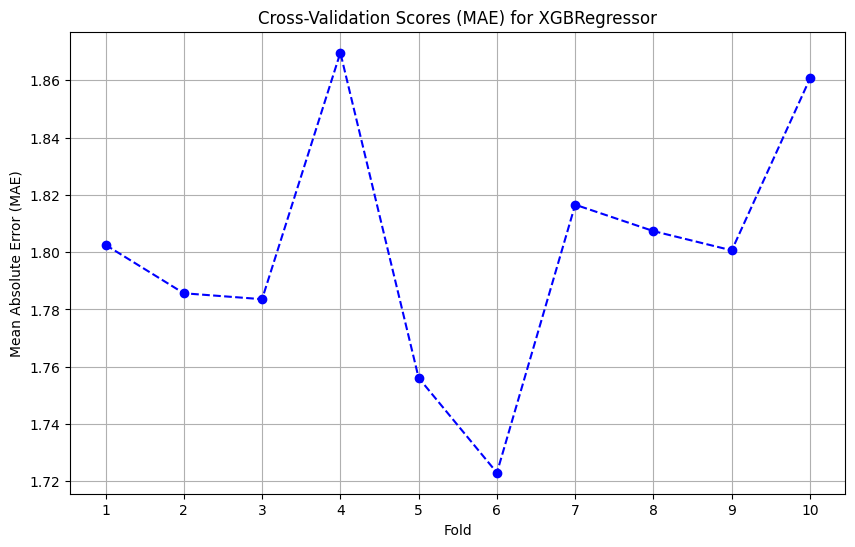

In [34]:
scores = [-score for score in scores]

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(scores, marker='o', linestyle='--', color='b')
plt.title('Cross-Validation Scores (MAE) for XGBRegressor')
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.xticks(range(10), range(1, 11))  # Adjust x-ticks to represent fold number
plt.show()

# 7. Improve the ML pipeline as follows

What we faced: While it generally recognizes that higher-rated wines should get higher predicted scores, there are noticeable deviations from the ideal prediction line. This suggests inaccuracy and potential bias, with overestimation at lower scores and underestimation at higher scores.

## 7.1 Perform better feature engineering and extraction

Data Cleaning: Handling Missing Values: Rows with missing values in the 'country' column were dropped. Missing values in the 'price' column were filled with the mean price of each respective country. Data Transformation: Column Subset: Selected a subset of columns including 'description', 'points', and 'price'. Normalization: Normalized numerical columns ('points' and 'price') to standardize their scales. Analysis: Textual and Quantitative Data:

The 'description' column provides textual information about each wine, describing its characteristics. 'points' represent the wine rating, and 'price' represents the cost of the wine. Normalized Values:

The 'points' and 'price' columns have been normalized, bringing them to a similar scale for improved analysis. Negative values in the normalized 'points' and 'price' columns indicate that the respective data points are below the mean. Relationships:

Analyzing the relationship between the textual descriptions and quantitative features could reveal interesting patterns. One could explore whether certain types of descriptions are associated with higher ratings or prices. Insights:

It would be interesting to identify any patterns in the descriptions that are correlated with higher or lower ratings ('points'). Examining how the 'description' content relates to both the rating and price could provide insights into the factors that contribute to wine quality and cost.

In [36]:

# Sometimes the price column is null. How many reviews in the dataset are missing a price?

missing_price_reviews = reviews[reviews.price.isnull()]
n_missing_prices = len(missing_price_reviews)

# Create a Series counting the number of times each value occurs in the region_1 field. This field is often missing data, so replace missing values with Unknown. Sort in descending order. Your output should look something like this:
reviews.region_1.fillna('unknown')
reviews.region_1.fillna('unknown').value_counts().sort_values(ascending = False)

missing_percentage = (wine_reviews.isnull().sum() / len(wine_reviews)) * 100
print("Percentage of missing values in each column:")
print(missing_percentage)

# Drop rows where both 'country' and 'price' have NaN values
wine_reviews_cleaned = wine_reviews.dropna(subset=['country', 'price']).copy()

# Calculate the mean price for each country
mean_price_by_country = wine_reviews_cleaned.groupby('country')['price'].mean()

# Fill missing values in 'price' column based on the mean price for each country. I decided filling with average values of each respective country rather
# than for the whole dataset is more intuitive
wine_reviews_cleaned['price'] = wine_reviews_cleaned.apply(
    lambda row: mean_price_by_country[row['country']] if pd.isnull(row['price']) else row['price'],
    axis=1
)

# Display the percentage of missing values in each column after filling 'price' column
missing_percentage_after_fill = (wine_reviews_cleaned.isnull().sum() / len(wine_reviews_cleaned)) * 100
print("Percentage of missing values in each column after filling 'price' column:")
print(missing_percentage_after_fill)

Create a DataFrame italian_wines containing reviews of wines made in Italy. Hint: reviews.country equals what?

italian_wines = reviews[reviews.country == 'Italy']



NameError: name 'reviews' is not defined

## 7.2 Implement/Choose a better ML model

### 7.2.1 Attempt 1: GradientBoostingRegressor

A first relatively naive attempt, would be to try and work with a different training arcithecture, results show this does not imporve the final score of the model, which brings us to the need to clean and arrange the data

In [ ]:
preprocessor = SimpleImputer(strategy='mean')  # Replace missing values with the mean
preprocessor = StandardScaler()

# Train
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
my_pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),('model', model_gb)])
my_pipeline_gb.fit(X_train, y_train)
# Test
predictions_gb = my_pipeline_gb.predict(X_test)

In [ ]:
evaluate_model(y_test, predictions_gb)

This isn't better than XGBRegressor

### 7.2.1 Attempt 2:

## 7.3 statistical evaluation

## 7.4 Error analysis

# 8. SHAP - Feature importance tools

# 9. Insights

# 10. Refer in your project to existing material


While the Wine Reviews dataset on Kaggle offers a wealth of existing notebooks for analysis, most concentrate on fundamental data analysis, manipulation techniques, and demonstrations of core concepts.  We've identified a few notebooks with relevant approaches, yet our solution offers distinct advantages:

-  Predict Wine Points: how to pick a wine
https://www.kaggle.com/code/kb2900/predict-wine-points-how-to-pick-a-wine

- Predicting Wine Quality using SVM,KNN(with EDA)

- https://www.kaggle.com/code/darthmanav/predicting-wine-quality-using-svm-knn-with-eda

- Good with cheeseburgers: predict wine from reviews
https://www.kaggle.com/code/kevintos/good-with-cheeseburgers-predict-wine-from-reviews

-  Predicting Wine Ratings Using LightGBM + Text2Vec
- https://www.kaggle.com/code/nnnnick/predicting-wine-ratings-using-lightgbm-text2vec

- Predict a wine's score based on its description (https://www.kaggle.com/code/inmanenz/predicting-wine-reviewers)

- Classification with NLP, XGBoost and Pipelines
 https://www.kaggle.com/code/diveki/
classification-with-nlp-xgboost-and-pipelines

- NLP + feature based points predictions
https://www.kaggle.com/code/mistrzuniu1/nlp-feature-based-points-predictions

https://www.kaggle.com/code/alabaj/wine-reviews-classification-tensorflow-lstm
- https://www.kaggle.com/code/sajjadfc13/day-1-regression-and-classification

-  Wine Analysis + Recommendation
- https://www.kaggle.com/code/chaitanya99/wine-analysis-recommendation


Unlike notebooks focusing on basic wine scores or quality predictions (like [Predicting Wine Quality using SVM,KNN], [Good with cheeseburgers], or [Predicting Wine Ratings Using LightGBM + Text2Vec]), our solution XXXX..TODO..

Our approach surpasses classification-centered notebooks ([Classification with NLP, XGBoost and Pipelines], [NLP + feature based points predictions]), offering...XXXXX

We build upon the strengths of analysis and recommendation works ([Wine Analysis + Recommendation]) by... showcase how we enhance these aspects

This positions our solution as a valuable extension of existing work on the Wine Reviews dataset, filling a gap by providing... Summarize the unique benefits my solution brings to the table
"


## how and why your pipeline is different from other available pipelines. Mention and provide citation/reference to any external resource (code, idea, technique) that you use.

# 11. Present the main, important parts of your full data science workflow and results in a user
friendly human-readable Jupyter Notebook, that contains markup, visualizations and short
block of code (long block should be deferred to external python files). Explain, and show how
you improved over the baseline model.